<a href="https://colab.research.google.com/github/jjsmartin/disaster-tweets/blob/main/nlp_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

bag of bigrams model -- should do better by FC rule of thumb

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split

# Download the data

In [2]:
# upload api key in kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonathanmartin","key":"76269bf5445db6d3e3fc46d21f08de6e"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 1.35MB/s]
100% 593k/593k [00:00<00:00, 1.35MB/s]


In [5]:
!unzip -qq nlp-getting-started.zip

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.shape, test_data.shape

((7613, 5), (3263, 4))

In [7]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# EDA

In [9]:
# What does a random-guess baseline give us? 1 = real disaster. Guessing 0 all the time gives us 0.57
train_data.target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [10]:
# how long are the texts?
train_data.text.str.len().mean(), train_data.text.str.len().max()

(101.03743596479706, 157)

In [11]:
# how many tokens are there?
unique_tokens = set(' '.join(train_data.text).split(' '))
len(unique_tokens)

32017

In [12]:
# urls, hashtags, proper nouns may be important but rare
random.sample(list(unique_tokens), 20)

['You...',
 'http://t.co/nY3l1oRZQb',
 'Holes',
 'campground',
 'Maxi',
 '101:',
 'see',
 'Desolation...',
 'forestservice',
 '#GujaratRiot',
 'BRUH',
 '@ictyosaur',
 "someone's",
 'social',
 'Actavis',
 'Kisii',
 'he',
 'athletics',
 '@bmurph1019',
 'wave?']

In [13]:
# what are the keyword and location columns?
train_data.keyword.value_counts(dropna=False)

NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [14]:
train_data.location.value_counts(dropna=False)

NaN                             2533
USA                              104
New York                          71
United States                     50
London                            45
                                ... 
Surulere Lagos,Home Of Swagg       1
MontrÌ©al, QuÌ©bec                 1
Montreal                           1
ÌÏT: 6.4682,3.18287                1
Lincoln                            1
Name: location, Length: 3342, dtype: int64

# better to use a sequence model or a bag-of-words model?

"pay close attention to the ratio between the number of samples in your training data and the mean number of words per sample.... If that ratio is small - less that 1,500 - then the bag-of-bigrams model will perform better.... If that ratio is higher than 1,500, then you should go with a sequence model."
(Chollet p349)

In [145]:
mean_words_per_sample = np.mean([len(txt.split(' ')) for txt in train_data.text])
num_samples = train_data.shape[0]

# 510: suggests that a bag-of-bigrams model will perform better
num_samples / mean_words_per_sample

509.9492230805779

In [142]:
train_data.text[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

# Load a pre-trained model

In [16]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=4fb79be63f73c4a750d3c987b00d1aec8c80ae4dd6f47995db22ec00e9e2a6c1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


# Prepare the data

In [17]:
from sentence_transformers import SentenceTransformer
#encoder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
encoder = SentenceTransformer('all-mpnet-base-v2')

In [18]:
# encoder vocabulary vs errors -- could lack of coverage of proper nouns be important?
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
vocabulary = tokenizer.get_vocab()

missing = []
for _, row in train_data.iterrows():
  tokens = row.text.split(' ')
  _missing = [token for token in tokens if token not in vocabulary]
  missing.append(_missing)

train_data['missing_tokens'] = missing
train_data['num_missing_tokens'] = [len(mssng) for mssng in missing]


missing = []
for _, row in test_data.iterrows():
  tokens = row.text.split(' ')
  _missing = [token for token in tokens if token not in vocabulary]
  missing.append(_missing)

test_data['missing_tokens'] = missing
test_data['num_missing_tokens'] = [len(mssng) for mssng in missing]

In [19]:
train_data.sample(10)

,id,keyword,location,text,target,missing_tokens,num_missing_tokens
3138,4509,emergency,USA,Deals : http://t.co/ddhWoRI5w1 #37592 Temporar...,0,"[Deals, http://t.co/ddhWoRI5w1, #37592, Tempor...",15
4341,6165,hijack,NaN,Swansea Û÷plot hijack transfer move for South...,1,"[Swansea, Û÷plot, hijack, Southampton, Virgil...",7
6589,9435,survivors,Anywhere Safe,@LawfulSurvivor T-Dog had been holed up in an ...,1,"[@LawfulSurvivor, T-Dog, holed, Glenn, Morales...",8
2654,3812,detonate,"Broomfield, CO",#Boulder deputies are waiting for the bomb squ...,1,"[#Boulder, detonate, Stearns, http://t.co/7cAD...",4
6309,9018,stretcher,NaN,Sweater Stretcher http://t.co/naTz5iPV1x http:...,0,"[Sweater, Stretcher, http://t.co/naTz5iPV1x, h...",4
2368,3405,derail,"Washington, DC 20009",Don't let #WMATA #Metro derail your day! Get a...,0,"[Don't, #WMATA, #Metro, derail, day!, Get, mor...",10
6587,9432,survivors,Shanghai,Survivors of Shanghai Ghetto reunite after 70 ...,0,"[Survivors, Shanghai, Ghetto, http://t.co/1Ki8...",7
936,1353,blown%20up,"Guildford, UK",'WeÛªre blown away by this extension. Nothing...,0,"['WeÛªre, extension., Nothing, weÛªve, one.'...",8
3115,4471,electrocuted,Oblivion?,Just thought I'd let you all know...\nIt's pro...,0,"[Just, I'd, know...\nIt's, hairdryer, it's, el...",6
4667,6634,inundated,NaN,@Legna989 you're correct it is coming from bot...,0,"[@Legna989, you're, sides., Maybe, I'm, FB, Re...",9


In [20]:
# split the data (in a way that let's us keep track of ordering, so we can inspect the results more easily)
X = train_data["text"].values
y = train_data["target"].values

split_point = int(0.2 * X.shape[0])

X_train = X[:-split_point]
y_train = y[:-split_point]
X_val = X[-split_point:]
y_val = y[-split_point:]



In [21]:
# create embeddings
X_train_text_encoded = encoder.encode(train_data[:-split_point]["text"].values)
X_val_text_encoded = encoder.encode(train_data[-split_point:]["text"].values)

X_full_train_text_encoded = encoder.encode(train_data["text"].fillna('').values)
y_full = train_data.target

# these don't seem worth it
# X_train_keywords_encoded = encoder.encode(train_data[:-split_point]["keyword"].fillna('').values)
# X_val_keywords_encoded = encoder.encode(train_data[-split_point:]["keyword"].fillna('').values)

# X_train_locations_encoded = encoder.encode(train_data[:-split_point]["location"].fillna('').values)
# X_val_locations_encoded = encoder.encode(train_data[-split_point:]["location"].fillna('').values)

# Nearest neighbours with the embeddings

Provide this as additional input? Some kind of ensemble?

In [22]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode

class KNN_Model:
    def __init__(self, k=5, algorithm='ball_tree'):
        self.k = k
        self.algorithm = algorithm
        self.nbrs = NearestNeighbors(n_neighbors=k+1, algorithm=self.algorithm)
        self.labels = None

    def fit(self, embeddings, labels):
        self.labels = labels
        self.nbrs.fit(embeddings)

    def predict(self, embeddings):
        distances, indices = self.nbrs.kneighbors(embeddings)

        # Exclude the first neighbor (which is the embedding itself)
        indices = indices[:, 1:]

        # Retrieve labels of nearest neighbors
        nn_labels = np.array(self.labels)[indices]

        # Get the most common label among k neighbors for each instance
        predicted_labels = mode(nn_labels, axis=1)[0]

        # also an average score
        scores = nn_labels.mean(axis=1)

        return predicted_labels.squeeze(), scores


In [23]:
knn_model = KNN_Model(k=10)
knn_model.fit(X_train_text_encoded, y_train)

In [24]:
X_val_text_encoded.shape

(1522, 768)

In [25]:
knn_labels, knn_scores = knn_model.predict(X_val_text_encoded)

<ipython-input-22-dd96ab7b4aba>:26: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  predicted_labels = mode(nn_labels, axis=1)[0]


# Keras model

In [27]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.2 MB/s eta 0:00:00


In [28]:
import kerastuner as kt

<ipython-input-28-5fd8096cdee5>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
####################################################################################
# WIP

In [162]:
# def build_model(hp):
#     inputs = keras.layers.Input(shape=(784,))

#     # Conditional layer: Decide between having a Dense layer or not
#     if hp.Choice('use_dense', [True, False]):
#         x = keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
#                                activation='relu')(inputs)
#         x = keras.layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1))(x)
#     else:
#         x = inputs

#     # Conditional layer type: Decide between using Dense or LSTM (assuming input is sequence data)
#     layer_type = hp.Choice('layer_type', ['dense', 'lstm'])
#     if layer_type == 'dense':
#         x = keras.layers.Dense(units=hp.Int('dense2_units', min_value=32, max_value=512, step=32),
#                                activation='relu')(x)
#     elif layer_type == 'lstm':
#         x = keras.layers.LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32))(x)

#     outputs = keras.layers.Dense(10, activation='softmax')(x)
#     model = keras.models.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model


In [ ]:
#
####################################################################################

In [181]:
def build_model(hp):

    inputs = keras.layers.Input(shape=(X_train_text_encoded[0].shape))

    x = layers.Dense(
        units=hp.Int('dense1_units', min_value=32, max_value=512, step=32),
        activation='relu')(inputs)

    x = layers.Dropout(hp.Choice('dropout1_frac', [0.2, 0.3, 0.4, 0.5]))(x)

    if hp.Choice('more_layers', [True, False]):
      x = layers.Dense(
          units=hp.Int('dense2_units', min_value=32, max_value=512, step=32),
          activation='relu')(x)

      x = layers.Dropout(hp.Choice('dropout2_frac', [0.2, 0.3, 0.4, 0.5]))(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.models.Model(inputs, outputs)

    model.compile(
        #optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        optimizer="rmsprop",
        loss='binary_crossentropy',
        metrics=['accuracy'])

    return model


In [182]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
    ]

In [186]:
from sklearn.model_selection import KFold

# Define KFold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)


tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=2,
    directory='tuning_results',
    overwrite=True
)

# Run the tuner for each fold
for train_indices, val_indices in kf.split(X_full_train_text_encoded):

    X_train, X_val = X_full_train_text_encoded[train_indices], X_full_train_text_encoded[val_indices]
    y_train, y_val = y_full[train_indices], y_full[val_indices]

    tuner.search(
        X_train,
        y_train,
        validation_data=(X_val, y_val))

Trial 50 Complete [00h 00m 07s]
val_accuracy: 0.8200919330120087

Best val_accuracy So Far: 0.8309257924556732
Total elapsed time: 00h 05m 25s


/content


In [121]:
# tuner.search(
#     X_train_text_encoded,
#     y_train,
#     epochs=10,
#     validation_data=(X_val_text_encoded, y_val),
#     callbacks=callbacks_list
#     )

In [166]:
top_n = 1
best_hps = tuner.get_best_hyperparameters(top_n)

In [178]:
best_hps[0].get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'dense1_units',
    'default': None,
    'conditions': [],
    'min_value': 32,
    'max_value': 512,
    'step': 32,
    'sampling': 'linear'}},
  {'class_name': 'Choice',
   'config': {'name': 'dropout1_frac',
    'default': 0.2,
    'conditions': [],
    'values': [0.2, 0.3, 0.4, 0.5],
    'ordered': True}},
  {'class_name': 'Choice',
   'config': {'name': 'more_layers',
    'default': 1,
    'conditions': [],
    'values': [1, 0],
    'ordered': True}}],
 'values': {'dense1_units': 224, 'dropout1_frac': 0.4, 'more_layers': 1}}

In [167]:
callbacks = keras.callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor="val_loss",
    save_best_only=True
)


In [180]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense_5 (Dense)             (None, 224)               172256    
                                                                 
 dropout_3 (Dropout)         (None, 224)               0         
                                                                 
 dense_6 (Dense)             (None, 224)               50400     
                                                                 
 dropout_4 (Dropout)         (None, 224)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 225       
                                                                 
Total params: 222,881
Trainable params: 222,881
Non-trainab

In [175]:
# refit the best model (but keeo holding out val_data for inspection of results)

model = build_model(best_hps[0])

history = model.fit(
    X_train_text_encoded,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_text_encoded, y_val),
    callbacks=callbacks
    )

Epoch 1/20
48/48 [==============================] - 4s 14ms/step - loss: 0.6857 - accuracy: 0.5749 - val_loss: 0.6707 - val_accuracy: 0.5703
Epoch 2/20
48/48 [==============================] - 0s 9ms/step - loss: 0.6727 - accuracy: 0.5762 - val_loss: 0.6518 - val_accuracy: 0.6314
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6582 - accuracy: 0.5986 - val_loss: 0.6301 - val_accuracy: 0.6373
Epoch 4/20
48/48 [==============================] - 0s 9ms/step - loss: 0.6370 - accuracy: 0.6347 - val_loss: 0.6115 - val_accuracy: 0.6938
Epoch 5/20
48/48 [==============================] - 0s 9ms/step - loss: 0.6235 - accuracy: 0.6616 - val_loss: 0.5701 - val_accuracy: 0.7181
Epoch 6/20
48/48 [==============================] - 0s 9ms/step - loss: 0.5939 - accuracy: 0.6892 - val_loss: 0.5371 - val_accuracy: 0.7319
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5574 - accuracy: 0.7188 - val_loss: 0.4876 - val_accuracy: 0.7845
Epoch 8/20
48/48 

In [169]:
model = keras.models.load_model('model.keras')
print(f"Validation accuracy: {model.evaluate(X_val_text_encoded, y_val)[1]: .3f}")

48/48 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5650
Validation accuracy:  0.565


In [170]:
history_df = pd.DataFrame(history.history)

Text(0.5, 1.0, 'Loss')

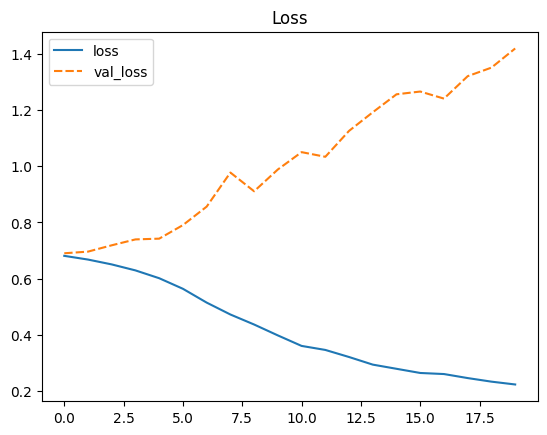

In [171]:
sns.lineplot(data=history_df.filter(regex="loss"))
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

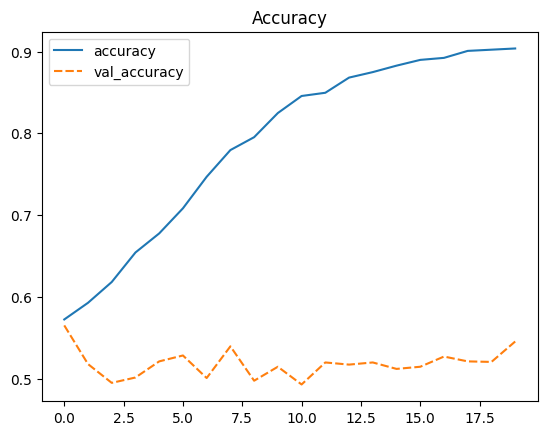

In [172]:
sns.lineplot(data=history_df.filter(regex="accuracy"))
plt.title("Accuracy")

# Inspect the results

In [58]:
preds = model.predict(X_val_text_encoded)

48/48 [==============================] - 0s 2ms/step


In [59]:
results = train_data[-split_point:].reset_index(drop=True)
results['predicted'] = preds
results['predicted_label'] = (preds > 0.5).astype('int64')

In [60]:
# include knn preds
results['knn_score'] = knn_scores
results['knn_label'] = knn_labels

In [61]:
false_positives = results.query("predicted_label == 1 and target == 0")
false_negatives = results.query("predicted_label == 0 and target == 1")

In [62]:
results.sample(10)

,id,keyword,location,text,target,missing_tokens,num_missing_tokens,predicted,predicted_label,knn_score,knn_label
787,9861,traumatised,NaN,I'm so traumatised.,0,"[I'm, traumatised.]",2,0.275046,0,0.2,0
614,9605,thunder,NaN,Thunder???,0,[Thunder???],1,0.600925,1,0.9,1
491,9421,survivors,Sao Paulo,Hiroshima survivors fight nuclear industry in ...,1,"[Hiroshima, Brazil, ÛÒ, http://t.co/uvM975yha2]",4,0.962012,1,1.0,1
1319,10601,wounded,"Illinois, USA",Let's not forget our wounded female veterans. ...,1,"[Let's, veterans., http://t.co/rZ7fbr10xw]",3,0.809057,1,0.6,1
1354,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0,"[Crack, I, run., Surface, knee., http://t.co/y...",6,0.637344,1,0.6,1
858,9971,tsunami,"Louavul, KY",#BBShelli seems pretty sure she's the one that...,0,"[#BBShelli, she's, that's, stay!, #BB17]",5,0.054734,0,0.1,0
413,9298,survive,Lincoln City Oregon,10 Ways To Survive and Escape Martial Law | Wo...,0,"[Ways, To, Survive, Escape, Martial, Law, Worl...",9,0.685875,1,0.8,1
1104,10307,weapon,NaN,@abcnews A nuclear bomb is a terrible weapon!!,1,"[@abcnews, A, weapon!!]",3,0.836036,1,0.8,1
422,9314,survive,NaN,A country Chim can survive!,1,"[A, Chim, survive!]",3,0.302530,0,0.4,0
1322,10606,wounded,USA,One man fatally shot another wounded on Vermon...,1,"[One, Vermont, Street, #Buffalo, http://t.co/8...",5,0.983976,1,1.0,1


In [63]:
false_positives.sample(10)

,id,keyword,location,text,target,missing_tokens,num_missing_tokens,predicted,predicted_label,knn_score,knn_label
855,9963,tsunami,in the Word of God,@freefromwolves GodsLove &amp; #thankU brother...,0,"[@freefromwolves, GodsLove, &amp;, #thankU, Da...",16,0.623432,1,0.8,1
523,9470,terrorism,Jeddah_Saudi Arabia.,In #islam saving a person is equal in reward t...,0,"[In, #islam, humans!, Islam, terrorism!]",5,0.702904,1,0.7,1
877,9994,tsunami,"Austin, TX",Dr. Jim &amp; the tsunami: The latest New York...,0,"[Dr., Jim, &amp;, tsunami:, The, New, Yorker, ...",13,0.920640,1,1.0,1
1354,10656,wounds,Lake Highlands,Crack in the path where I wiped out this morni...,0,"[Crack, I, run., Surface, knee., http://t.co/y...",6,0.637344,1,0.6,1
867,9983,tsunami,"Winter Park, Colorado",'Anyway' the old lady went on 'I have somethin...,0,"['Anyway', 'I, alone.', THE, COMING, TSUNAMI, ...",7,0.767192,1,0.8,1
1267,10535,windstorm,"Galveston, Texas",For sixth year in a row premium costs for wind...,0,"[For, windstorm, climb., This, percent., #Galv...",8,0.970171,1,1.0,1
570,9548,threat,Hyrule,@KingGerudo_ to the largest moblin's he'd leav...,0,"[@KingGerudo_, moblin's, he'd, Red, fired., Wi...",7,0.513780,1,0.5,0
153,8920,snowstorm,Deployed in the Middle East,@CacheAdvance besides your nasty thunderstorm ...,0,"[@CacheAdvance, thunderstorm, snowstorm, nah.,...",7,0.619757,1,0.9,1
882,10003,tsunami,BROKE NIGGAS DREAM!!,I want some tsunami take out,0,[I],1,0.729679,1,0.4,0
1385,10693,wreck,Pratt-on-Wye,How many cars do those cyclists wreck going pa...,0,"[How, pedals., They, #c4news]",4,0.677489,1,0.4,0


In [ ]:
false_negatives.sample(10)

,id,keyword,location,text,target,missing_tokens,num_missing_tokens,predicted,predicted_label,knn_score,knn_label
476,9397,survivors,NaN,Tricycle toddler atomic bomb\nhttp://t.co/ljeR...,1,"[Tricycle, toddler, bomb\nhttp://t.co/ljeRYHIt...",6,0.369419,0,1.0,1
749,9797,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1,"[Hollywood, Movie, About, Trapped, Miners, Rel...",12,0.370695,0,0.4,0
738,9780,trapped,876 Jamrock.,Literally trapped in my room Cuz my bathroom b...,1,"[Literally, Cuz, remodeled., The]",4,0.130504,0,0.4,0
1430,10754,wreckage,Punjab,Wreckage 'Conclusively Confirmed' as From MH37...,1,"[Wreckage, 'Conclusively, Confirmed', From, MH...",7,0.488076,0,1.0,1
1229,10479,wild%20fires,NaN,@EnzasBargains A5 Donated some fruit snacks &a...,1,"[@EnzasBargains, A5, Donated, &amp;, handi, wi...",8,0.180075,0,1.0,1
1442,10771,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1,"[Wreckage, 'Conclusively, Confirmed', From, MH...",7,0.488076,0,1.0,1
1219,10462,wild%20fires,Madrid,In Europe nature is kind while in US they have...,1,"[In, Europe, US, tornados, droughts.]",5,0.406647,0,1.0,1
875,9991,tsunami,in the Word of God,@author_mike Amen today is the Day of Salvatio...,1,"[@author_mike, Amen, Day, Salvation., THX, Mik...",11,0.488633,0,0.3,0
553,9513,terrorist,"BILASPUR,CHHATTISGARH,495001",The Pak terrorist who has been caught alive mu...,1,"[The, Pak, KasabWe, Pak, Biryani]",5,0.276730,0,0.5,0
792,9868,traumatised,Scotland,@PyramidHead76 one good thing came out of watc...,1,"[@PyramidHead76, film., , Was, traumatised, Ha...",11,0.292056,0,0.2,0


In [64]:
results.num_missing_tokens.mean(), false_positives.num_missing_tokens.mean(), false_negatives.num_missing_tokens.mean()

(6.823915900131406, 7.111111111111111, 6.19375)

In [65]:
# compare knn and the main model
pd.crosstab(results.predicted_label, results.knn_label)

knn_label,0,1
predicted_label,,
0,710,182
1,29,601


In [66]:
results['mean_prediction'] = (results[['predicted', 'knn_score']].mean(1) > 0.5).astype('int64')
results['max_prediction']  = (results[['predicted', 'knn_score']].max(1) > 0.5).astype('int64')
results['min_prediction']  = (results[['predicted', 'knn_score']].min(1) > 0.5).astype('int64')

In [67]:
def accuracy(preds, actual):
  return sum(preds == actual) / len(preds)

In [68]:
accuracy(results.predicted_label, results.target)

0.8416557161629435

In [69]:
accuracy(results.knn_label, results.target)

0.80946123521682

In [70]:
accuracy(results.mean_prediction, results.target)

0.842969776609724

In [71]:
accuracy(results.max_prediction, results.target)

0.8061760840998686

In [72]:
accuracy(results.min_prediction, results.target)

0.8449408672798949

# Refit the model with all the training data

(and an extra epoch because there's more data)

In [74]:
# create embeddings
X_full_train_text_encoded = encoder.encode(train_data["text"].fillna('').values)
# X_full_train_keywords_encoded  = encoder.encode(train_data["keyword"].fillna('').values)
# X_full_train_locations_encoded = encoder.encode(train_data["location"].fillna('').values)

y_full = train_data.target

In [75]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

In [76]:
model.fit(
    X_full_train_text_encoded,
    y_full,
    epochs=7,  # adjust manually
    batch_size=32
    )

Epoch 1/7
238/238 [==============================] - 3s 5ms/step - loss: 0.3315 - accuracy: 0.8623
Epoch 2/7
238/238 [==============================] - 1s 5ms/step - loss: 0.2971 - accuracy: 0.8798
Epoch 3/7
238/238 [==============================] - 1s 5ms/step - loss: 0.2690 - accuracy: 0.8923
Epoch 4/7
238/238 [==============================] - 2s 7ms/step - loss: 0.2371 - accuracy: 0.9087
Epoch 5/7
238/238 [==============================] - 2s 7ms/step - loss: 0.2039 - accuracy: 0.9218
Epoch 6/7
238/238 [==============================] - 3s 12ms/step - loss: 0.1791 - accuracy: 0.9310
Epoch 7/7
238/238 [==============================] - 3s 12ms/step - loss: 0.1511 - accuracy: 0.9435


In [77]:
knn_model = KNN_Model(k=10)
knn_model.fit(X_full_train_text_encoded, y_full)

# Submission

In [78]:
# create embeddings for the test data
X_test_text_encoded      = encoder.encode(test_data["text"].fillna('').values)
# X_test_keywords_encoded  = encoder.encode(test_data["keyword"].fillna('').values)
# X_test_locations_encoded = encoder.encode(test_data["location"].fillna('').values)

In [79]:
keras_preds = model.predict(X_test_text_encoded)

102/102 [==============================] - 0s 2ms/step


In [80]:
_, knn_preds = knn_model.predict(X_test_text_encoded)

<ipython-input-22-dd96ab7b4aba>:26: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  predicted_labels = mode(nn_labels, axis=1)[0]


In [81]:
keras_preds.squeeze().shape, knn_preds.shape, X_test_text_encoded.shape

((3263,), (3263,), (3263, 768))

In [82]:
# min score actually better than mean?
#min_scores = np.min([keras_preds.squeeze(), knn_preds], axis=0)

In [89]:
predicted_labels = (min_scores > 0.5).astype('int64')

In [91]:
submission = pd.read_csv("sample_submission.csv")
submission["target"] = predicted_labels

In [92]:
submission.to_csv("submission.csv", index=False)

In [93]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "Limited hyperparameter search (ignore knn model)"

100% 22.2k/22.2k [00:00<00:00, 30.4kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets



# results

https://www.kaggle.com/competitions/nlp-getting-started/submissions
